# Example: Doing Extreme Value Analysis (EVA) for time series 

This example illustrates how to use to perform Extreme Value Analysis (EVA) based on time series stored in a netcdf, for example, this could be performed on a xarray Dataset. 
Typical steps needed to perform EVA are:
- extract peaks (high extremes) from a continuous time series
- fit a EV distribution on these peaks 
- obtain return values for given return periods based on the distribution fitted and its parameters
- plot the distribution and empirical data 

All these steps are also combined in the function `eva` (see also the end of the example)

We cover these steps in this example using randomly generated data. More details on the functions used can be found in the API reference description of the [Statistics and Extreme Value Analysis](../api/stats.rst#statistics-and-extreme-value-analysis)

Note that here are also other packages for extreme valua analysis. 

- [scipy.stats](https://docs.scipy.org/doc/scipy/tutorial/stats.html) Library of many statistical distributions including extreme value distributions.
- [pyextremes](https://georgebv.github.io/pyextremes/) Very rich package for univariate extreme value analysis with many different fitting methods, builds on scipy.stats.

Compared to these packages The HydroMT methods add the following features, but is generally much less feature rich:
- support for performing extreme valua analysis on ND Xarray Datasets
- support for lmoments fitting

In [1]:
# import hydromt and functions needed for EVA
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from hydromt.stats import extremes

We load a random discharge time seriesaas a xarray DataArray `da` for two stations (stations 1 and 2). 

In [2]:
# We create some random continuous time series with some extremes
da = xr.open_dataarray(r"./data/discharge.nc")
da

<xarray.DataArray 'discharge' (time: 10958, stations: 2)> Size: 88kB
[21916 values with dtype=float32]
Coordinates:
  * time      (time) datetime64[ns] 88kB 1992-01-01 1992-01-02 ... 2021-12-31
  * stations  (stations) int32 8B 1 2
Attributes:
    long_name:  discharge
    units:      m3/s

Extreme value distribution fit is based either on block maxima (BM) or peaks-over-threshold (PoT). 

- If sampling of high extremes is done according to BM then, distributions to be fit are either Gumbel (later referred as `gumb`) or the Generalized Extreme Value (GEV) distribution (later referred as `gev`). Note that a GEV distribution with a shape paramater of 0 is equivalent to the Gumbel distribution.  

- If sampling of high extremes is done according to PoT then, distributions to be fit are either exponential (later referred as `exp`) or the Generalized Pareto (GP) distribution (later referred as `gpd`). 

For this example, we will fit a GEV distribution based on annual maxima. 

## Step 1: Extracting peaks from continuous time series

<Axes: xlabel='time', ylabel='discharge [m3/s]'>

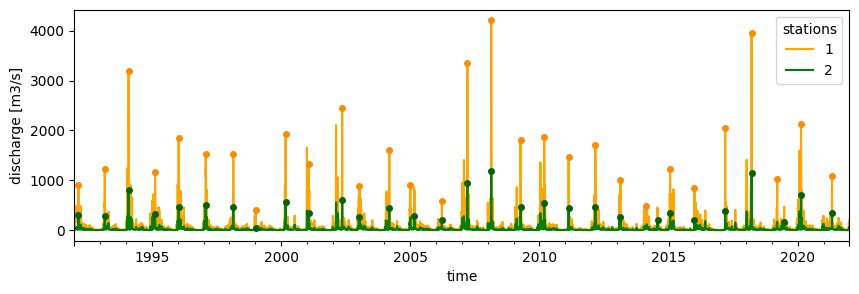

In [3]:
# We use the get_peaks function
bm_peaks = extremes.get_peaks(da, ev_type="BM", period="365.25D")

fig, ax = plt.subplots(figsize=(10, 3))
da.to_pandas().plot(
    ax=ax, xlabel="time", ylabel="discharge [m3/s]", color=["orange", "green"]
)
bm_peaks.to_pandas().plot(
    ax=ax,
    marker="o",
    linestyle="none",
    legend=False,
    color=["darkorange", "darkgreen"],
    markersize=4,
)

The function extracts peaks, here, annual maxima, and set the rest of the time series to NaN. Here, the `extremes_rate` is equal to 1 as we have sampled the highest value per year.

## Step 2: fit a EV distribution on these peaks 

In [4]:
da_params = extremes.fit_extremes(bm_peaks, ev_type="BM", distribution="gev")
da_params.load()

<xarray.DataArray 'parameters' (stations: 2, dparams: 3)> Size: 48B
array([[-1.43938489e-01,  1.18602378e+03,  6.36962648e+02],
       [-1.60420677e-01,  3.23741304e+02,  1.75376325e+02]])
Coordinates:
  * stations       (stations) int32 8B 1 2
    extremes_rate  (stations) float64 16B 1.0 1.0
  * dparams        (dparams) <U5 60B 'shape' 'loc' 'scale'
    distribution   (stations) <U3 24B 'gev' 'gev'

## Step 3: obtain return values for given return periods based on the distribution fitted and its parameters

In [5]:
# We define the return periods for which we would like to know the return values
rps = np.array([2, 5, 25, 100, 500])
da_rps = extremes.get_return_value(da_params, rps=rps).load()
da_rps.to_pandas()

rps,2,5,25,100,500
stations,,,,,
1,1425.770861,2252.428221,3773.468116,5341.066751,7584.131635
2,389.952957,621.148509,1056.736145,1517.185877,2192.705849


## Step 4: plot the distribution and empirical data

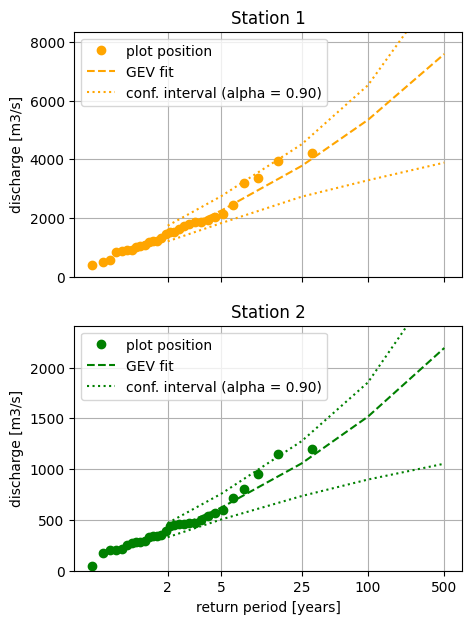

In [6]:
# We plot the fit obtained using the function plot_return_values!

fig, axes = plt.subplots(2, 1, figsize=(5, 7), sharex=True)

for i, ax, color in zip(da.stations.values, axes, ["orange", "green"]):
    extremes.plot_return_values(
        bm_peaks.sel(stations=i),
        da_params.sel(stations=i),
        "gev",
        color=color,
        nsample=1000,  # number of samples for confidence interval
        rps=rps,
        extremes_rate=1.0,
        ax=ax,
    )
    ax.set_title(f"Station {i}")
    ax.set_ylabel("discharge [m3/s]")
    if i == da.stations.values[-1]:
        ax.set_xlabel("return period [years]")
    else:
        ax.set_xlabel("")

## TL;DR
Note that the EV fit can be done within one function ([stats.extremes.eva]) that subsequently calls the functions used here ([stats.extremes.get_peaks], [stats.extremes.fit_extremes] and [stats.extremes.get_return_value])

Steps 1 to 3 above could have been performed using [stats.extremes.eva] as follow. In this case, it will return an xarray.Dataset:

In [7]:
da_bm_eva = extremes.eva(
    da, ev_type="BM", period="365.25D", distribution="gev", rps=rps
).load()

da_bm_eva

<xarray.Dataset> Size: 176kB
Dimensions:        (time: 10958, stations: 2, dparams: 3, rps: 5)
Coordinates:
  * time           (time) datetime64[ns] 88kB 1992-01-01 ... 2021-12-31
  * stations       (stations) int32 8B 1 2
    extremes_rate  (stations) float64 16B 1.0 1.0
  * dparams        (dparams) <U5 60B 'shape' 'loc' 'scale'
    distribution   (stations) <U3 24B 'gev' 'gev'
  * rps            (rps) int64 40B 2 5 25 100 500
Data variables:
    peaks          (time, stations) float32 88kB nan nan nan nan ... nan nan nan
    parameters     (stations, dparams) float64 48B -0.1439 1.186e+03 ... 175.4
    return_values  (stations, rps) float64 80B 1.426e+03 2.252e+03 ... 2.193e+03
Attributes:
    long_name:  discharge
    units:      m3/s

Note that for this example:
- `da_bm_eva['peaks']` is the same as `bm_peaks`
- `da_bm_eva['parameters']` is the same as `da_params`
- `da_bm_eva['return_values']` is the same as `da_rps`